### W10_Tue
#### Our model is performing poorly on testRegion5. We think the problem is because we don't have any data from this region in training the model
#### Resample whole Australia, 10 yrs. Ensure that it covers all country and still has enough points for the 5 test regions

In [73]:
submission = pd.read_csv('so_far_best.csv')
submission[submission['decimalLongitude'] > 152].groupby('occurrenceStatus').count()


,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
1,663,663,663


In [83]:
# change all values within this range to 0
submission.loc[submission['decimalLongitude'] > 152, 'occurrenceStatus'] = 0
submission[submission['decimalLongitude'] > 152]['occurrenceStatus']

2662    0
2663    0
2664    0
2665    0
2666    0
       ..
3320    0
3321    0
3322    0
3323    0
3324    0
Name: occurrenceStatus, Length: 663, dtype: int64

In [62]:
import warnings
warnings.filterwarnings('ignore')
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Data science
import pandas as pd
import numpy as np

# Read in data, drop useless columns, check null values
df = pd.read_csv('climate_frog1020.csv').drop(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'country', 'continent'],axis = 1)
print(df.shape)
df.isnull().sum()

# To make EDA easier, create new column of year & new column of month, type int
year = []
month = []
for i in df['eventDate']:
    year.append(int(str(i).split('-')[0]))
    month.append(int(str(i).split('-')[1]))
df['year'] = year
df['month'] = month

df = df.sort_values(by = 'eventDate')

# Drop some columns so that we only have the 7 vars we care about
df = df.drop(['def_mean','q_mean','vpd_mean','ws_mean'],axis =1)

FileNotFoundError: [Errno 2] No such file or directory: 'climate_frog1020.csv'

In [7]:
df.groupby('occurrenceStatus').count()

,gbifID,eventDate,stateProvince,decimalLatitude,decimalLongitude,species,coordinateUncertaintyInMeters,key,aet_mean,pet_mean,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,year,month
occurrenceStatus,,,,,,,,,,,,,,,,,
0,31666,31666,31666,31666,31666,31666,31666,31666,31310,31310,31310,31310,31310,31310,31310,31666,31666
1,31676,31676,31676,31676,31676,31676,31676,31676,31430,31430,31430,31430,31430,31430,31430,31676,31676


In [8]:
df.describe()['coordinateUncertaintyInMeters']

count    63342.000000
mean        27.016342
std         32.402840
min          1.000000
25%          5.000000
50%         10.000000
75%         34.400000
max        100.000000
Name: coordinateUncertaintyInMeters, dtype: float64

In [9]:
print('min Long: ', df['decimalLongitude'].min(), ' max Long: ', df['decimalLongitude'].max())
print('min Lat: ', df['decimalLatitude'].min(), ' max Lat: ', df['decimalLatitude'].max())

min Long:  135.783  max Long:  153.63
min Lat:  -43.473672  max Lat:  -16.250838


#### This means we already have this problem when we limited uncertainty to 100. So we need to read in again. 

### Use join_frog & all the nc files, get a new training df
- After some searching, we find that when dropping frog occurrence data from occurrence_raw to 30k_frogs, we already filtered by their Uncertainty, which means we probably already dropped test_region5. 
- We go back to the step of creating the 30k_frogs, and try to rejoin a new frog data with the climate nv files from the 10 years
- The notebooks are all in Git. 30k_frogs is created by dataset_summary_OccurrenceEDA, and the final dataframe is combined in join_climatefrog_1

In [24]:
# Geospatial
# import contextily as cx
# import xarray as xr
# import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac
import pandas as pd
import numpy as np
# Other
import os
import zipfile
from itertools import cycle

In [26]:
# First deal with frog occurrence df
data = pd.read_csv('occurrence_raw.csv',parse_dates=['eventDate']).dropna()
data = data[(data['species']== 'Litoria Fallax') | (data['species']== 'Crinia Signifera')]

# since some data is too early, only take things after 2010
data = data[lambda x: (x.eventDate.dt.year >= 2010) & (x.eventDate.dt.year <=2020) ]
print(data.shape)
data.describe()

(106874, 10)


,Unnamed: 0,gbifID,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters
count,106874.000000,1.068740e+05,106874.000000,106874.000000,1.068740e+05
mean,75921.302262,3.115214e+09,-33.720132,149.494710,3.924529e+02
std,52394.194218,6.344582e+08,3.567709,3.350384,4.845476e+03
min,7.000000,3.320324e+08,-43.609343,135.274000,1.000000e+00
25%,33813.250000,3.108873e+09,-35.411093,148.276138,5.000000e+00
50%,64212.500000,3.463511e+09,-33.835933,150.865180,1.200000e+01
75%,111256.750000,3.463624e+09,-33.133173,151.365000,9.789750e+01
max,193513.000000,3.468734e+09,-16.066700,153.630000,1.445600e+06


In [42]:
# check how many 1's
data[data['species'] == 'Litoria Fallax'].shape

(36039, 10)

### Generate pseudo absence points

Australia:
max_lat = -9.9, min_lat = -43.56, min_long = 112, max_long = 154

In [43]:
# big bounding rectangle with no presence points but with points are outside of australia
max_lat = -9.9
min_lat = -32.9
min_long = 112
max_long = 135
rect = (min_long, min_lat, max_long, max_lat)

In [46]:
step = np.arange(1,1000,0.01) # Could be something like myRange = range(1,1000,1)
df = pd.DataFrame({"latitude": np.arange(min_lat, max_lat, 0.00001), 
                   'longitude': np.arange(min_long, max_long, 0.00001)})
df = df[df['latitude'] > -30]
df.shape

(2010000, 2)

In [61]:
random = df.sample(30000, random_state=42).reset_index(drop=True)
random

,latitude,longitude
0,-18.44997,126.45003
1,-20.71741,124.18259
2,-12.39905,132.50095
3,-13.90167,130.99833
4,-11.97327,132.92673
...,...,...
29995,-10.24091,134.65909
29996,-21.40178,123.49822
29997,-23.33564,121.56436
29998,-21.65095,123.24905


In [60]:
# random.to_csv('pseudo_absence.csv')

#### We now need to get weather data for these 30000 random pseudo absence points generated --> will be less than 30000 after matching with the weather data since some random points generated would be out of range


#### Notice that starting from here, we don't have any data for region5

In [35]:
data.groupby('species').count()

,Unnamed: 0,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters
species,,,,,,,,,
Crinia Signifera,70835,70835,70835,70835,70835,70835,70835,70835,70835
Litoria Fallax,36039,36039,36039,36039,36039,36039,36039,36039,36039


In [156]:
# Class Balance
target_species = 'Litoria Fallax'
 
data = (
    data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
 
target_species_frog_data = data[data.occurrenceStatus== 1]
frog_data = (
    data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
frog_data

,Unnamed: 0,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,coordinateUncertaintyInMeters,occurrenceStatus,key
0,38262,3463713400,2018-07-12 00:00:00,Australia,Australia,Victoria,-37.807578,145.263468,Crinia Signifera,65.0,0,0
1,41245,3463679952,2020-10-06 00:00:00,Australia,Australia,New South Wales,-33.714199,151.088463,Crinia Signifera,10.0,0,1
2,80999,3463591513,2018-07-09 00:00:00,Australia,Australia,New South Wales,-33.763524,151.237485,Crinia Signifera,5.0,0,2
3,118095,1453027595,2016-09-22 00:00:00,Australia,Australia,New South Wales,-30.695676,152.758627,Crinia Signifera,10.0,0,3
4,38285,3463713488,2020-04-03 00:00:00,Australia,Australia,New South Wales,-33.324500,151.365000,Crinia Signifera,3.9,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
72073,193485,2806356042,2010-12-17 00:00:00,Australia,Australia,New South Wales,-33.835933,151.062409,Litoria Fallax,100.0,1,72073
72074,193486,3108865868,2019-02-03 00:00:00,Australia,Australia,New South Wales,-34.028797,151.225626,Litoria Fallax,6.0,1,72074
72075,193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax,31.0,1,72075
72076,193509,2557751115,2020-01-08 23:38:00,Australia,Australia,New South Wales,-31.941704,152.400911,Litoria Fallax,8.0,1,72076


In [158]:
frog_data[frog_data['stateProvince'] == 'Australian Capital Territory'][['decimalLatitude','decimalLongitude']].describe()

,decimalLatitude,decimalLongitude
count,1101.000000,1101.000000
mean,-35.305739,149.126525
std,0.145584,0.256995
min,-35.860300,148.778031
25%,-35.339418,149.040000
50%,-35.273362,149.110044
75%,-35.212100,149.154000
max,-35.124508,150.762611


In [160]:
frog_data[frog_data['occurrenceStatus'] == 0].groupby('stateProvince')['stateProvince'].count()

stateProvince
Australian Capital Territory     1097
Jervis Bay Territory                1
New South Wales                 22656
Queensland                        283
South Australia                  1890
Tasmania                          903
Victoria                         9209
Name: stateProvince, dtype: int64

### So, this is doable, but there is no frog occurrence data in test_region5 over the 10 years. 
1. See if we need to get earlier data. How early do we need to go?
2. See if we can predict test region 5 using climate vars. 
3. Other than that, is there enought data for the other 4 regions? 
**We'll first try out the 3rd option**

In [41]:
# Read in our current training data
df = pd.read_csv('climate_frog1520_7vars.csv')
# Test Region 1
print(df[(df['decimalLatitude']>=-38.5) & (df['decimalLatitude']<= -37.5) 
   & (df['decimalLongitude']>=144.8) & (df['decimalLongitude']<= 145.8) ].shape)
# Test Region 2
print(df[(df['decimalLatitude']>=-33.5) & (df['decimalLatitude']<= -32.5) 
   & (df['decimalLongitude']>=150.7) & (df['decimalLongitude']<= 151.7) ].shape)
# Test Region 3
print(df[(df['decimalLatitude']>=-29) & (df['decimalLatitude']<= -28) 
   & (df['decimalLongitude']>=152.6) & (df['decimalLongitude']<= 153.6) ].shape)
# Test Region 4
print(df[(df['decimalLatitude']>=-17.7) & (df['decimalLatitude']<= -16.7) 
   & (df['decimalLongitude']>=145) & (df['decimalLongitude']<= 146) ].shape)
# Test Region 5
print(df[(df['decimalLongitude']<= 116.7) & (df['decimalLongitude']>=115.7) 
    & (df['decimalLatitude']<= -31.5) & (df['decimalLatitude']>=-32.5)].shape)


(1005, 19)
(6459, 19)
(1080, 19)
(647, 19)
(0, 19)


In [42]:
# What if we take 2010-2020 data?
df = frog_data
# Test Region 1
print(df[(df['decimalLatitude']>=-38.5) & (df['decimalLatitude']<= -37.5) 
   & (df['decimalLongitude']>=144.8) & (df['decimalLongitude']<= 145.8) ].shape)
# Test Region 2
print(df[(df['decimalLatitude']>=-33.5) & (df['decimalLatitude']<= -32.5) 
   & (df['decimalLongitude']>=150.7) & (df['decimalLongitude']<= 151.7) ].shape)
# Test Region 3
print(df[(df['decimalLatitude']>=-29) & (df['decimalLatitude']<= -28) 
   & (df['decimalLongitude']>=152.6) & (df['decimalLongitude']<= 153.6) ].shape)
# Test Region 4
print(df[(df['decimalLatitude']>=-17.7) & (df['decimalLatitude']<= -16.7) 
   & (df['decimalLongitude']>=145) & (df['decimalLongitude']<= 146) ].shape)
# Test Region 5
print(df[(df['decimalLongitude']<= 116.7) & (df['decimalLongitude']>=115.7) 
    & (df['decimalLatitude']<= -31.5) & (df['decimalLatitude']>=-32.5)].shape)

(2556, 12)
(10425, 12)
(2094, 12)
(1031, 12)
(0, 12)


- This shows that if we don't limit by uncertainty and take 10 yrs, we still don't have any data for region 5, but we will have about twice more data for regions 1-4

**Now let's do the 2nd option**
1. see if the climate vars of our current region5 differ from the other 4 regions & other places greatly
        - Based on the graphs, we see that the model can probably get fooled by tmax, tmin, and vap. For all the other 4 vars, test region 5 is an outlier
        - If we join presence and climates, we loose the information we have about test region 5. So now we have 2 options:
            - 1. Fake/ get some new occurrence data, so that test region 5 is all absence
*The main methods that are currently used to generate pseudo-absence points are:* 
1) randomly generated pseudo-absence locations from background data; 
2) pseudo-absence locations generated within a delimited geographical distance from recorded presence points; and 
3) pseudo-absence locations selected in areas that are environmentally dissimilar from presence points.*

            - 2. Make our algorithm know that aet, pet, ppt, and srad are IMPORTANT and we CANNOT go over the max/ minimum

In [58]:
# Read in the other 4 regions. 
tr1 = pd.read_csv('testRegion1.csv').assign(region = 1)
tr2 = pd.read_csv('testRegion2.csv').assign(region = 2)
tr3 = pd.read_csv('testRegion3.csv').assign(region = 3)
tr4 = pd.read_csv('testRegion4.csv').assign(region = 4)
tr5 = pd.read_csv('testRegion5.csv').assign(region = 5)

# Do a comparison between the 5, a comparison between testRegion5 and our current train df
testRegions = pd.concat([tr1,tr2,tr3,tr4,tr5])

In [110]:
testRegions.columns

Index(['Unnamed: 0', 'id', 'decimalLongitude', 'decimalLatitude', 'key',
       'aet_mean', 'pet_mean', 'ppt_mean', 'srad_mean', 'tmax_mean',
       'tmin_mean', 'vap_mean', 'region'],
      dtype='object')

In [112]:
testRegions.groupby('region').describe()[['aet_mean', 'pet_mean', 'ppt_mean', 'srad_mean', 'tmax_mean',
       'tmin_mean', 'vap_mean']]

aet_mean                                                           \
          count        mean        std        min        25%         50%   
region                                                                     
1        1491.0   55.868735   8.456827  36.383335  51.366665   56.416668   
2        1147.0   70.187416  10.494953  43.766666  60.858333   73.300000   
3         663.0   88.357919   6.618314  55.483334  86.825001   88.866670   
4         128.0  102.809506  12.951822  67.650000  94.516670  104.316666   
5         598.0   47.160312   2.485144  34.833332  45.966667   47.100000   

                               pet_mean              ...  tmin_mean  \
               75%         max    count        mean  ...        75%   
region                                               ...              
1        59.050000   76.983330   1491.0  108.970635  ...  10.455002   
2        78.650000   85.000000   1147.0  116.098140  ...  13.403336   
3        93.008332   96.816666    663.0  120.920338  ...  15.043335   
4       115.716670  123.566666    128.0  137.697006  ...  20.820004   
5        48.483334   53.683334    598.0  138.985480  ...  13.283335   

                  vap_mean                                                    \
              max    count      mean       std       min       25%       50%   
region                                                                         
1       10.901669   1491.0  1.110463  0.035409  0.929333  1.085667  1.109167   
2       14.248335   1147.0  1.402573  0.058770  1.251833  1.358500  1.408167   
3       15.793334    663.0  1.648856  0.084910  1.337500  1.604833  1.693667   
4       20.881670    128.0  2.143531  0.232796  1.705833  1.924000  2.231667   
5       13.560000    598.0  1.306463  0.063692  1.138667  1.305833  1.332167   

                            
             75%       max  
region                      
1       1.133250  1.193333  
2       1.456500  1.486167  
3       1.705000  1.759833  
4       2.360667  2.422833  
5       1.344500  1.387000  

[5 rows x 56 columns]

<AxesSubplot:xlabel='region', ylabel='vap_mean'>

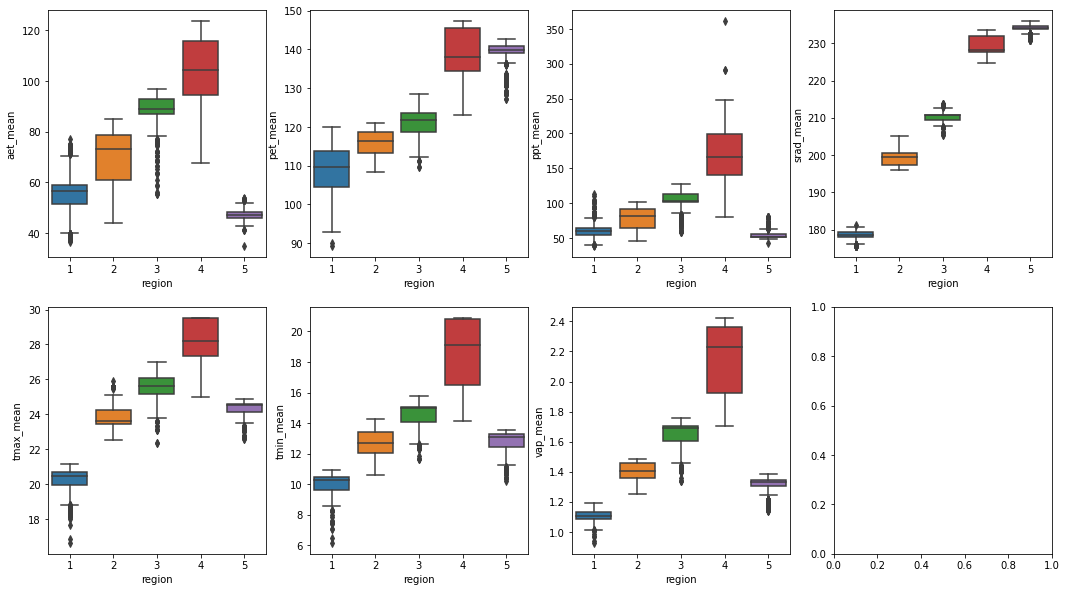

In [150]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
sns.boxplot(x = 'region', y = 'aet_mean', data = testRegions,ax = axes[0,0] )
sns.boxplot(x = 'region', y = 'pet_mean', data = testRegions, ax = axes[0,1] )
sns.boxplot(x = 'region', y = 'ppt_mean', data = testRegions, ax = axes[0,2])
sns.boxplot(x = 'region', y = 'srad_mean', data = testRegions,ax = axes[0,3])
sns.boxplot(x = 'region', y = 'tmax_mean', data = testRegions, ax = axes[1,0])
sns.boxplot(x = 'region', y = 'tmin_mean', data = testRegions, ax = axes[1,1])
sns.boxplot(x = 'region', y = 'vap_mean', data = testRegions, ax = axes[1,2])

**Before we make a decision, take a look at how does the graphs of our current training df vary among regions**

In [141]:
# Read in our current train df
df = pd.read_csv('climate_frog1520_7vars.csv')
# Test Region 1
df1 = df[(df['decimalLatitude']>=-38.5) & (df['decimalLatitude']<= -37.5) 
   & (df['decimalLongitude']>=144.8) & (df['decimalLongitude']<= 145.8) ].assign(region = 1)
# Test Region 2
df2 = df[(df['decimalLatitude']>=-33.5) & (df['decimalLatitude']<= -32.5) 
   & (df['decimalLongitude']>=150.7) & (df['decimalLongitude']<= 151.7) ].assign(region = 2)
# Test Region 3
df3 = df[(df['decimalLatitude']>=-29) & (df['decimalLatitude']<= -28) 
   & (df['decimalLongitude']>=152.6) & (df['decimalLongitude']<= 153.6) ].assign(region = 3)
# Test Region 4
df4 = df[(df['decimalLatitude']>=-17.7) & (df['decimalLatitude']<= -16.7) 
   & (df['decimalLongitude']>=145) & (df['decimalLongitude']<= 146) ].assign(region = 4)
# Test Region 5
df5 = df[(df['decimalLongitude']<= 116.7) & (df['decimalLongitude']>=115.7) 
    & (df['decimalLatitude']<= -31.5) & (df['decimalLatitude']>=-32.5)].assign(region = 5)

<AxesSubplot:xlabel='region', ylabel='srad_mean'>

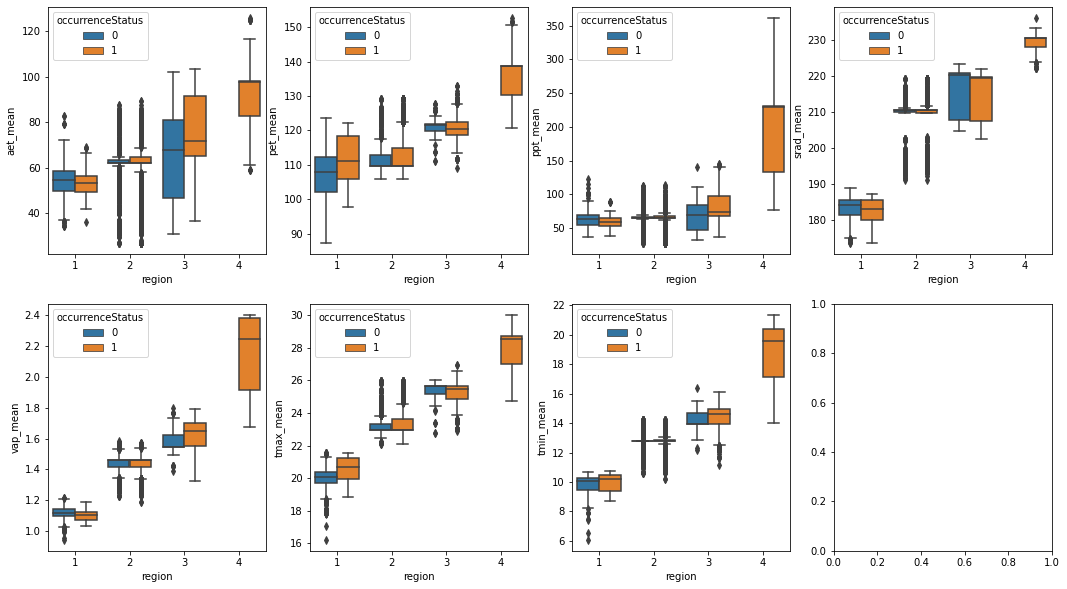

In [151]:
train5Regions = pd.concat([df1,df2,df3,df4,df5])
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
sns.boxplot(ax = axes[0,0], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'aet_mean')
sns.boxplot(ax = axes[0,1], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'pet_mean')
sns.boxplot(ax = axes[0,2], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'ppt_mean')
sns.boxplot(ax = axes[1,0], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'vap_mean')
sns.boxplot(ax = axes[1,1], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'tmax_mean')
sns.boxplot(ax = axes[1,2], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'tmin_mean')
sns.boxplot(ax = axes[0,3], data = train5Regions, hue= 'occurrenceStatus', x = 'region', y = 'srad_mean')

**This shows that we don't have any data for the 5th test region, which has 4/7 outlier variables**

**We also don't have any ABSENCE data for the 4th test region, which is 6/7 outlier variables**

#### What if we go with generating pseudo-absence data using "dissimilar environment features" as criteria? 
Let's first see what other features we can use. We can choose from 11 vars

In [ ]:
# read in our 11vars file
df11 = pd.read_csv('')

In [162]:
w1 = xr.open_dataarray('weather_data_1012.nc')
w2 = xr.open_dataarray('weather_data_1314.nc')
w3 = xr.open_dataarray('weather_data_1516.nc')
w4 = xr.open_dataarray('weather_data_17.nc')
w5 = xr.open_dataarray('weather_data_18.nc')
w6 = xr.open_dataarray('weather_data_1920.nc')
#weather_data = xr.merge([w1,w2,w3,w4,w5,w6]).to_array()

In [184]:
w3

<xarray.DataArray (band: 11, y: 512, x: 512)>
[2883584 values with dtype=float64]
Coordinates:
  * x        (x) float64 112.0 112.1 112.2 112.2 ... 153.8 153.8 153.9 154.0
  * y        (y) float64 -43.65 -43.58 -43.52 -43.45 ... -10.03 -9.966 -9.9
  * band     (band) object 'tmax_mean' 'tmin_mean' ... 'q_mean' 'vpd_mean'

In [183]:
w3.coords

Coordinates:
  * x        (x) float64 112.0 112.1 112.2 112.2 ... 153.8 153.8 153.9 154.0
  * y        (y) float64 -43.65 -43.58 -43.52 -43.45 ... -10.03 -9.966 -9.9
  * band     (band) object 'tmax_mean' 'tmin_mean' ... 'q_mean' 'vpd_mean'

In [186]:
stacked = w3.stack(z=("y", "x")).unstack()
stacked

<xarray.DataArray (band: 11, y: 512, x: 512)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band     (band) object 'tmax_mean' 'tmin_mean' ... 'q_mean' 'vpd_mean'
  * y        (y) float64 -43.65 -43.58 -43.52 -43.45 ... -10.03 -9.966 -9.9
  * x        (x) float64 112.0 112.1 112.2 112.2 ... 153.8 153.8 153.9 154.0

In [187]:
w3.to_dataframe(name= ['x'], dim_order = ['x', 'y','band']).dropna()

x
x          y          band                 
112.986301 -25.817319 tmax_mean   27.929168
                      tmin_mean   16.604169
                      ppt_mean    20.125000
                      srad_mean  243.958333
                      vap_mean     1.674167
...                                     ...
154.000000 -11.353033 aet_mean   126.166667
                      def_mean     8.166667
                      pet_mean   134.291667
                      q_mean     108.750000
                      vpd_mean     0.610833

[1432376 rows x 1 columns]

In [168]:
weather1 = w1.rename('data').sel(
                x=xr.DataArray(coords.decimalLongitude, dims="key", coords={"key": coords.key}), 
                y=xr.DataArray(coords.decimalLatitude, dims="key", coords={"key": coords.key}),
                method="nearest"
            ).to_dataframe().assign(val = lambda x: x.iloc[:, -1])[['val']].reset_index().drop_duplicates().pivot(index="key", columns="band", values="val").reset_index()

NameError: name 'coords' is not defined